In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.12.0


In [2]:
az.style.use("arviz-darkgrid")

# Model comparison
PyMC でのモデル比較基準の使用を実証するために、Gelman et al (2003) のセクション 5.5 の **8 校** の例を実装します。これは、8 校の生徒の SAT スコアに対するコーチングの効果を推測することを試みます。 以下では、すべての学校にわたる単一の固定効果を仮定する **プール モデル**と、データを部分的にプールするランダム効果を考慮する **階層モデル**を当てはめます。

データには、8 つの学校で観察された治療効果 (```y```) と関連する標準偏差 (```sigma```) が含まれます。

In [3]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
J = len(y)

## Pooled model

In [4]:
with pm.Model() as pooled:
    # Latent pooled effect size
    mu = pm.Normal("mu", 0, sigma = 1e6)

    obs = pm.Normal("obs", mu, sigma = sigma, observed = y)

    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


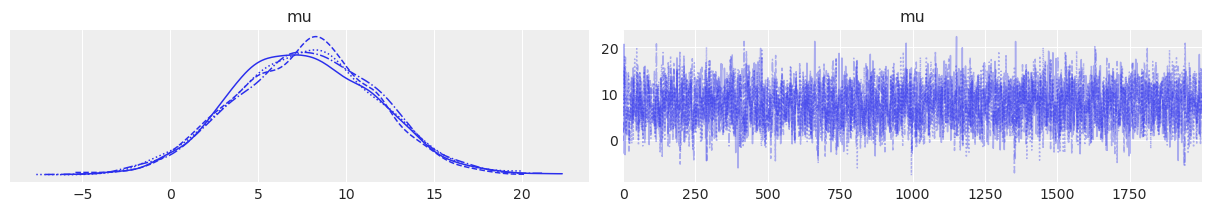

In [5]:
az.plot_trace(trace_p);

## Hierarchical model

In [6]:
with pm.Model() as hierarchical:
    eta = pm.Normal("eta", 0, 1, shape = J)
    # Hierarchical mean and SD
    mu = pm.Normal("mu", 0, sigma = 10)
    tau = pm.HalfNormal("tau", 10)

    # Non-centered parameterization of random effect
    theta = pm.Deterministic("theta", mu + tau * eta)

    obs = pm.Normal("obs", theta, sigma = sigma, observed = y)

    trace_h = pm.sample(2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, mu, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


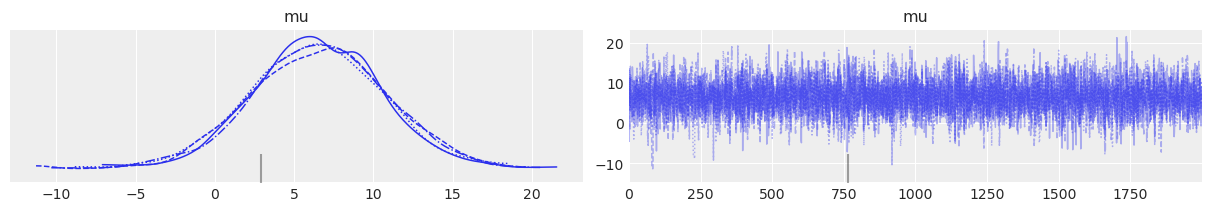

In [7]:
az.plot_trace(trace_h, var_names="mu");

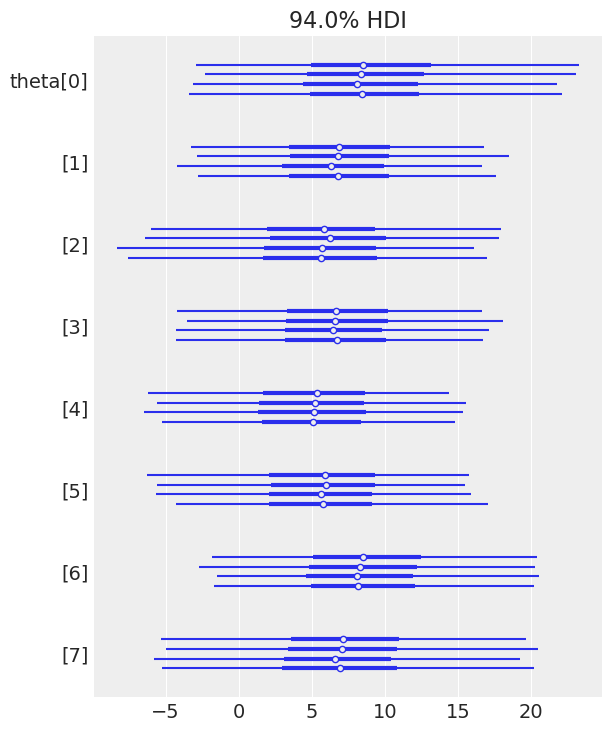

In [8]:
az.plot_forest(trace_h, var_names="theta");

## Leave-one-out Cross-validation (LOO)
LOO 相互検証は、サンプル外の予測適合の推定値です。 相互検証では、データがトレーニング セットとホールドアウト セットに繰り返し分割され、モデルを前者に繰り返し適合させ、ホールドアウト データとの適合を評価します。 ヴェタリら。 (2016) MCMC サンプルからの LOO の効率的な計算を導入しました (データを再フィッティングする必要はありません)。 この近似は重要度サンプリングに基づいています。 重要度の重みは、パレート平滑化重要度サンプリング (PSIS) として知られる方法を使用して安定化されます。

## Widely-applicable Information Criterion (WAIC)
WAIC (Watanabe 2010) は、計算された対数点ごとの事後予測密度 (LPPD) を使用し、オーバーフィッティングを調整するために有効なパラメーター数を補正する、サンプル外の期待値を推定するための完全なベイズ基準です。

デフォルトでは、ArviZ は LOO を使用しますが、WAIC も使用できます。

## Model log-likelihood
LOO と WAIC を計算するために、ArviZ はすべての事後サンプルのモデル要素ごとの対数尤度にアクセスする必要があります。 [compute_log_likelihood()](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.compute_log_likelihood.html#pymc.compute_log_likelihood) を介して追加できます。 あるいは、 ``idata_kwargs={"log_likelihood": True}`` を ``sample()`` に渡して、サンプリングの終了時に自動的に計算させることもできます。

In [9]:
with pooled:
    pm.compute_log_likelihood(trace_p)

In [10]:
pooled_loo = az.loo(trace_p)

pooled_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.55     1.11
p_loo        0.67        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [11]:
with hierarchical:
    pm.compute_log_likelihood(trace_h)

In [12]:
hierarchical_loo = az.loo(trace_h)

hierarchical_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.79     1.09
p_loo        1.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        3   37.5%
 (0.5, 0.7]   (ok)          5   62.5%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [13]:
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.550995,0.666563,0.000000,1.000000e+00,1.109041,0.000000,False,log
hierarchical,1,-30.787696,1.152980,0.236701,2.220446e-16,1.085885,0.224667,False,log


たくさんのコラムがあるので、一つ一つ意味を確認してみましょう:

0. インデックスは、``compare(.)`` に渡される辞書のキーから取得されたモデルの名前です。

1. rank, 0 (最良のモデル) からモデル数までのモデルのランキング。
1. loo, LOO (または WAIC) の値。 データフレームは常に、最良の LOO/WAIC から最悪の順に並べ替えられます。
1. p_loo, ペナルティ期間の値。 この値は、パラメータの推定有効数と大まかに考えることができます (ただし、あまり真剣に考えないでください)。
1. d_loo, 上位モデルのLOO/WAIC値と各モデルのLOO/WAIC値との相対差。 このため、最初のモデルでは常に 0 の値が得られます。
1. weight, 各モデルに割り当てられた重み。 これらの重みは、データが与えられた場合に (比較されたモデルの中で) 各モデルが真である確率として大まかに解釈できます。
1. se, LOO/WAIC 計算の標準誤差。 標準誤差は、LOO/WAIC 推定値の不確実性を評価するのに役立ちます。 デフォルトでは、これらのエラーはスタッキングを使用して計算されます。
1. dse, LOO/WAIC の 2 つの値の差の標準誤差。 LOO/WAIC の各値の標準誤差を計算するのと同じ方法で、LOO/WAIC の 2 つの値の差の標準誤差を計算できます。 両方の量が必ずしも同じではないことに注意してください。その理由は、LOO/WAIC に関する不確実性がモデル間で相関しているためです。 最上位モデルではこの数量は常に 0 になります。
1. warning, ``True``の場合、LOO/WAIC の計算は信頼できない可能性があります。
1. loo_scale, 報告される値のスケール。 デフォルトは、前述したように対数スケールです。 他のオプションは、逸脱 – これは、対数スコアに -2 を乗算したものです (これにより、順序が逆転します。LOO/WAIC が低いほど優れています) – および負の対数 – これは、対数スコアに -1 を乗算したものです ( 逸脱スケール、値が低いほど優れています)。


2 番目の便利な関数は、``compare``の出力を受け取り、Richard McElreath の書籍 [Statistical Re Thinking](https://xcelab.net/rm/statistical-rethinking/) で使用されているスタイルで要約プロットを生成します (次の例の [this port](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3) も確認してください)。 この本は PyMC に提供されます。

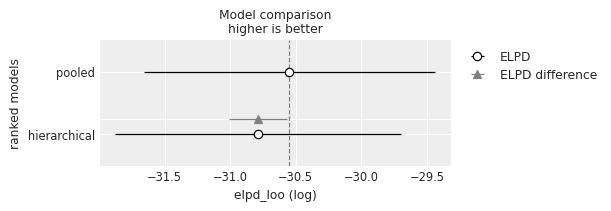

In [14]:
az.plot_compare(df_comp_loo, insample_dev=False);

白丸は LOO の値を表し、それらに関連付けられた黒い誤差バーは LOO の標準偏差の値です。

最高の LOO の値、つまり最良の推定モデルも、他の LOO 値との比較を容易にするために、灰色の垂直破線で示されます。

最上位のモデルを除くすべてのモデルについては、そのモデルと最上位のモデル間の WAIC の差の値を示す三角形と、最上位の WAIC とそのモデルの WAIC の差の標準誤差を示す灰色のエラー バーも表示されます。 各モデル。

## Interpretation
階層モデルが完全なプーリング モデルよりも優れたパフォーマンスを発揮すると予想されるかもしれませんが、両方のモデルが情報基準の非常に似た値を与えることを考えると、この場合、モデル間で選択できることはほとんどありません。 このことは、LOO と WAIC の不確実性 (標準誤差の観点から) を考慮するとより明確になります。

## Reference
[Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and Computing, 24(6), 997–1016.](https://link.springer.com/article/10.1007/s11222-013-9416-2)

[Vehtari, A, Gelman, A, Gabry, J. (2016). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and Computing](https://link.springer.com/article/10.1007/s11222-016-9696-4)

In [15]:
%load_ext watermark

%watermark -n -u -v -iv -w -p xarray,pytensor

Last updated: Thu Apr 04 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

xarray  : 2024.3.0
pytensor: 2.19.0

pymc      : 5.12.0
arviz     : 0.17.1
matplotlib: 3.8.3
numpy     : 1.26.4

Watermark: 2.4.3

